In [8]:
library(data.table) 
library(ggplot2)
library(pheatmap)
library(grid)


## Visualisation of concordance between genetic and hashing deconvolution methods through confusion matrix

In [4]:
# Load the genetic and hashing result for comparison
hash_gene_result <- fread("../data/pipeline_output/gx12/assignment_all_genetic_and_hash_with_hashedDrops.csv")

# Remove the trial ID
colnames(hash_gene_result) <- gsub("_1", "", colnames(hash_gene_result))

# Rename the donor id of vireo 
hash_gene_result$vireo <- gsub("donor", "", hash_gene_result$vireo)

# Rename the hashtag names of hashing methods
hash_gene_result$htodemux <- gsub("-TotalSeqA", "", hash_gene_result$htodemux)
hash_gene_result$multiseq <- gsub("-TotalSeqA", "", hash_gene_result$multiseq)
hash_gene_result$demuxem <- gsub("_TotalSeqA", "", hash_gene_result$demuxem)
hash_gene_result$hashsolo <- gsub("_TotalSeqA", "", hash_gene_result$hashsolo)

# Rename HashedDrops donor
hash_gene_result$hashedDrops <- ifelse(hash_gene_result$hashedDrops != 'negative', 
                                        paste0("Hash45", hash_gene_result$hashedDrops), 
                                        hash_gene_result$hashedDrops)

# Subset by only those cells detected by RNA
white_list_gx12 <- fread("../data/dataset/barcodes_gx12.tsv", header = F)$V1
hash_gene_result <- hash_gene_result[Barcode %in% white_list_gx12,]

head(hash_gene_result)

Barcode,demuxem,hashsolo,htodemux,multiseq,hashedDrops,freemuxlet,scsplit,souporcell,vireo
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGTGTGAC-1,Hash454,Hash453,Hash453,Hash454,negative,5,6,4,1
AAACCCAGTGAGAGGG-1,Hash453,Hash453,negative,doublet,NA,4,1,5,2
AAACGAAAGAATCTAG-1,negative,Hash453,negative,negative,negative,2,5,2,5
AAACGAACACATATGC-1,Hash456,Hash453,negative,negative,negative,2,0,2,5
AAACGAACACGACTAT-1,Hash452,Hash453,Hash453,Hash452,negative,2,0,2,5
AAACGAACATCAGCAT-1,negative,Hash453,Hash453,negative,negative,1,3,0,0


,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
Hash451,3,360,10,2,7,6
Hash452,15,23,22,9,4,197
Hash453,11,14,132,3,1,8
Hash454,243,4,6,1,0,1
Hash455,0,2,6,3,49,2
Hash456,16,50,54,332,11,37


pdf 
  3

pdf 
  4

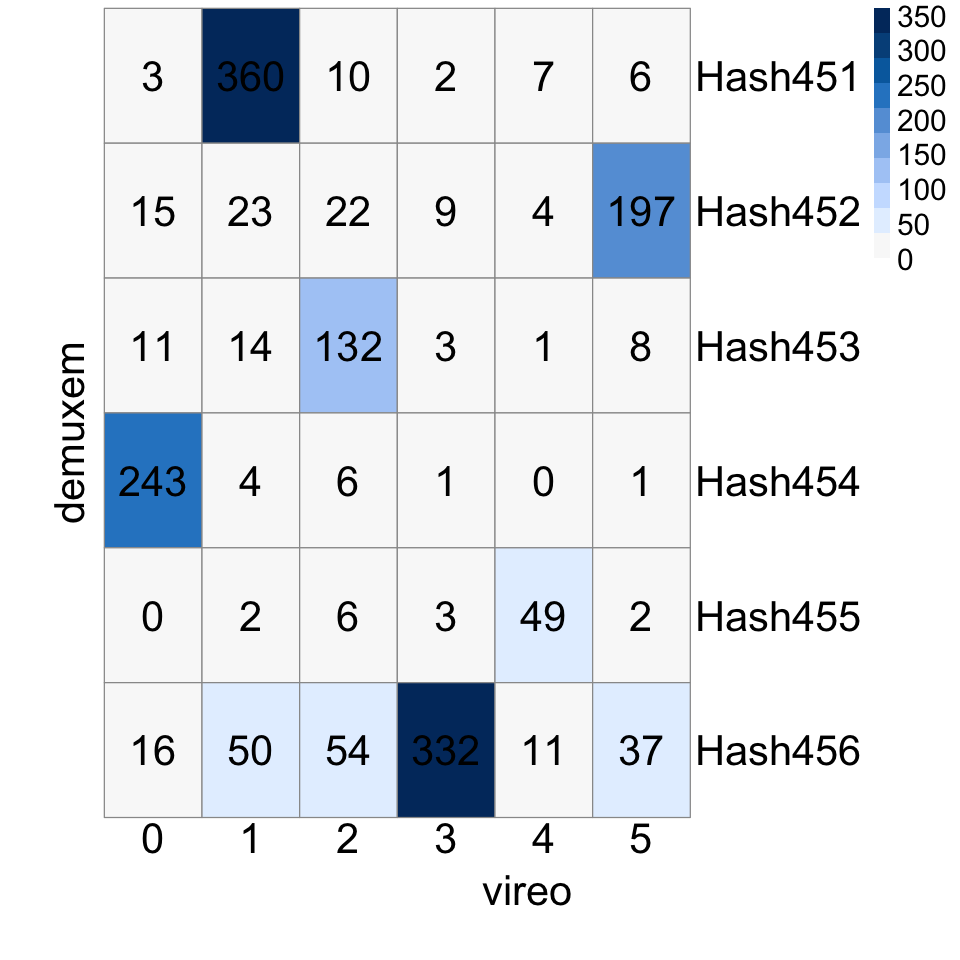

In [9]:
# Create an empyt matrix
confusion_matrix_v_demuxem = as.data.frame(matrix(ncol = 6, nrow = 6))
donor_list = paste0("Hash45",1:6)
donor_list_vireo = 0:5
colnames(confusion_matrix_v_demuxem) = donor_list_vireo
rownames(confusion_matrix_v_demuxem) = donor_list

for (j in c(0:5)){
  for (i in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$vireo == donor_list_vireo[j+1] &
                                  hash_gene_result$demuxem == donor_list[i],])
    confusion_matrix_v_demuxem[i, j+1] = row
  }
}

confusion_matrix_v_demuxem

pdf("S15-heatmap-v-demuxem-gx12.pdf", width=11, height=11)

# Change plot size to 8 x 8
options(repr.plot.width=8, repr.plot.height=8)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_demuxem, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("demuxem", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
Hash451,0,281,6,3,5,3
Hash452,6,22,22,8,5,230
Hash453,21,75,210,36,18,26
Hash454,282,3,3,2,0,3
Hash455,16,28,29,18,86,20
Hash456,1,6,8,193,2,5


pdf 
  3

pdf 
  4

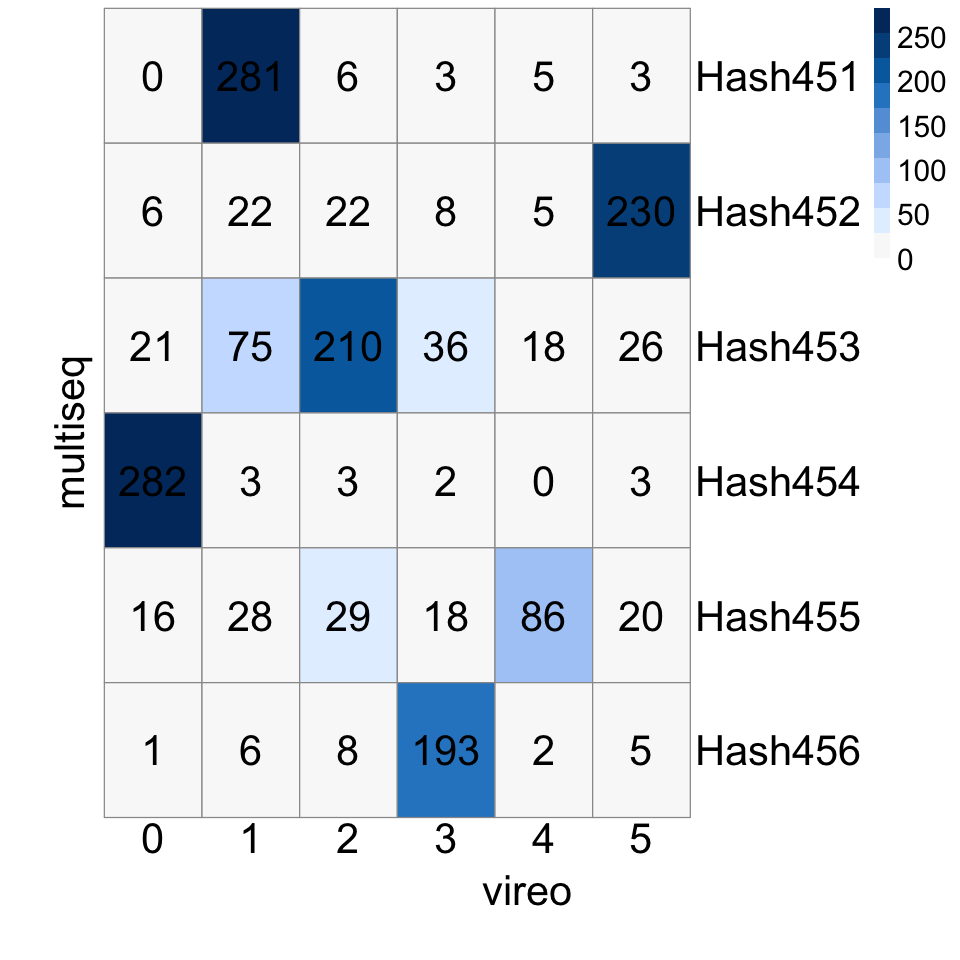

In [10]:
# Create an empyt matrix

confusion_matrix_v_multiseq = as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_multiseq) = donor_list_vireo
rownames(confusion_matrix_v_multiseq) = donor_list

for (j in c(0:5)){
  for (i in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$vireo == donor_list_vireo[j+1] &
                                  hash_gene_result$multiseq == donor_list[i],])
    confusion_matrix_v_multiseq[i, j+1] = row
  }
}

confusion_matrix_v_multiseq

pdf("S16-heatmap-v-multiseq-gx12.pdf", width=11, height=11)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_multiseq, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, cluster_rows = F, fontsize_row = 25, fontsize_col = 25, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("multiseq", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
Hash451,0,83,1,2,0,2
Hash452,0,0,0,0,0,6
Hash453,496,162,124,176,63,149
Hash454,3,0,0,0,0,0
Hash455,0,0,0,1,0,0
Hash456,0,0,0,6,0,0


pdf 
  3

pdf 
  4

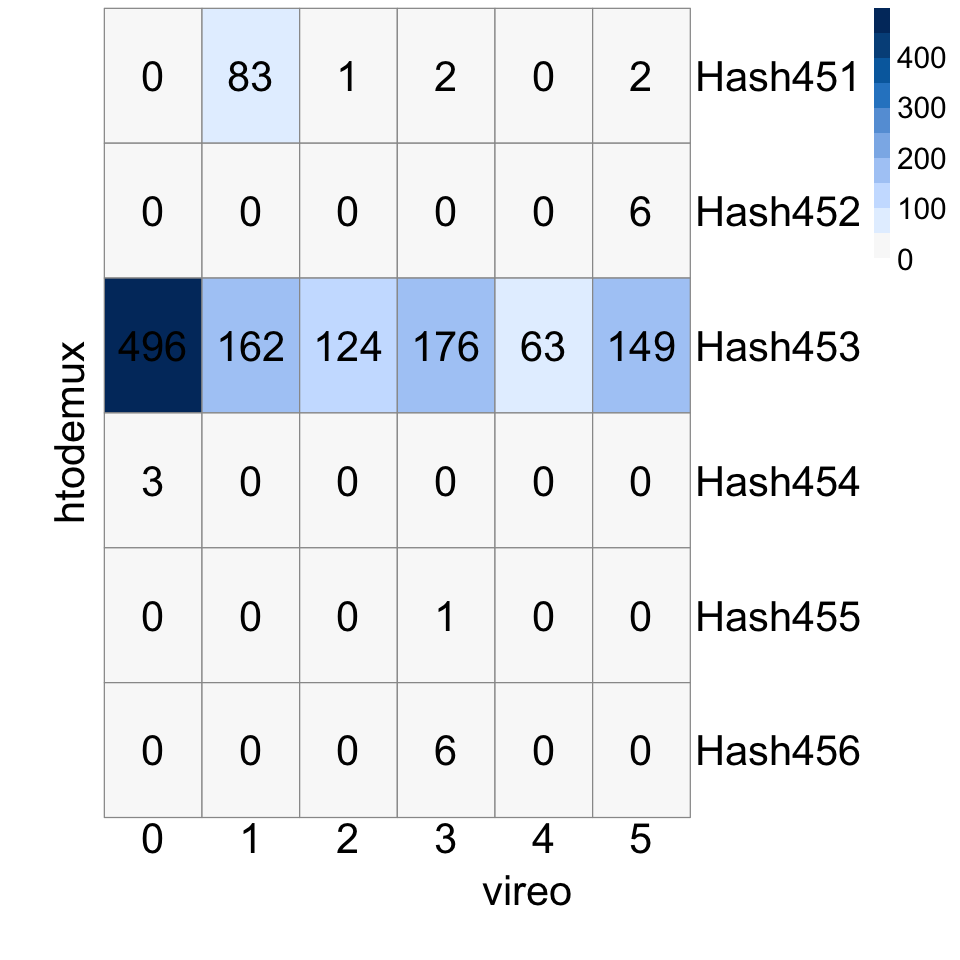

In [11]:
confusion_matrix_v_htodemux = as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_htodemux) = donor_list_vireo
rownames(confusion_matrix_v_htodemux) = donor_list

for (j in c(0:5)){
  for (i in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$vireo == donor_list_vireo[j+1] &
                                  hash_gene_result$htodemux == donor_list[i],])
    confusion_matrix_v_htodemux[i, j+1] = row
  }
}

confusion_matrix_v_htodemux

pdf("S17-heatmap-v-htodemux-gx12.pdf", width=11, height=11)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_htodemux, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("htodemux", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
Hash451,0,1,0,0,0,0
Hash452,0,0,0,0,0,0
Hash453,755,1090,796,625,242,692
Hash454,0,0,0,0,0,0
Hash455,0,0,0,0,0,0
Hash456,0,0,0,0,0,0


pdf 
  3

pdf 
  4

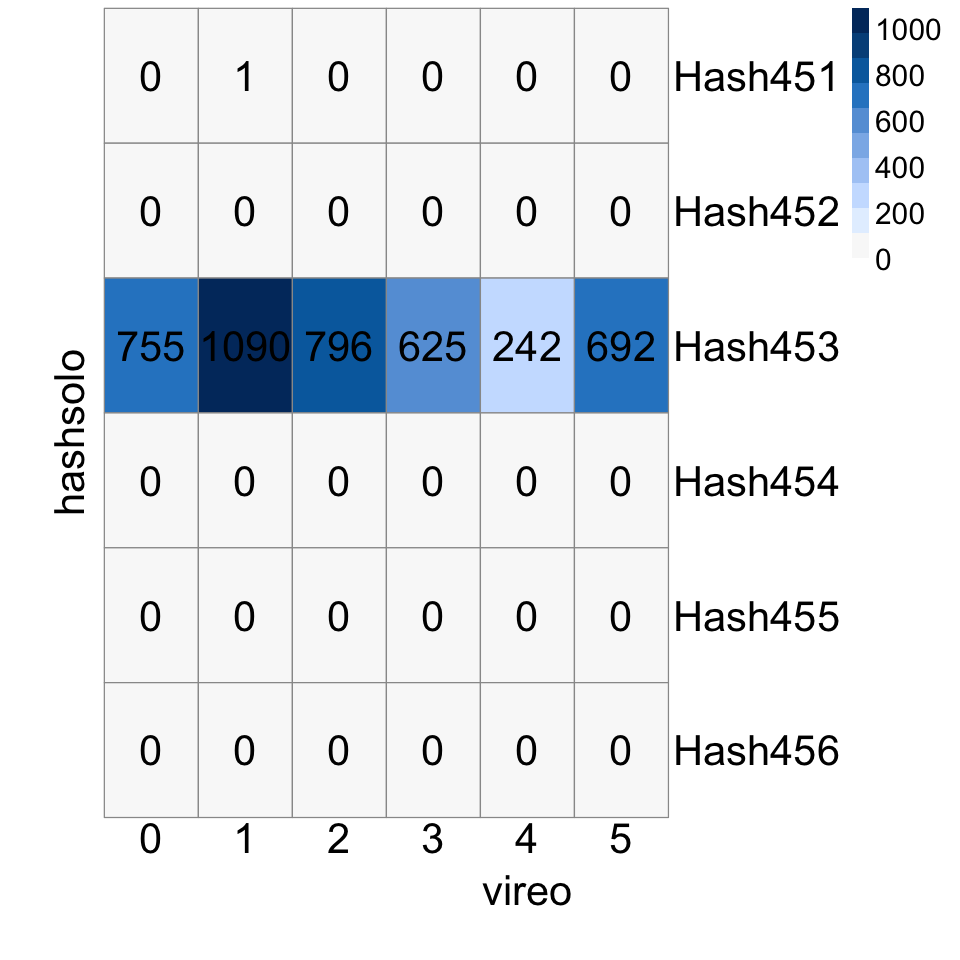

In [13]:
confusion_matrix_v_hashsolo = as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_hashsolo) = donor_list_vireo
rownames(confusion_matrix_v_hashsolo) = donor_list

for (j in c(0:5)){
  for (i in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$vireo == donor_list_vireo[j+1] &
                                  hash_gene_result$hashsolo == donor_list[i],])
    confusion_matrix_v_hashsolo[i, j+1] = row
  }
}

confusion_matrix_v_hashsolo

pdf("S18-heatmap-v-hashsolo-gx12.pdf", width=11, height=11)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_hashsolo, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("hashsolo", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
Hash451,0,19,0,0,0,1
Hash452,0,0,0,0,0,1
Hash453,0,0,4,0,0,0
Hash454,3,0,0,0,0,0
Hash455,0,0,0,1,0,0
Hash456,0,0,0,3,0,0


pdf 
  3

pdf 
  4

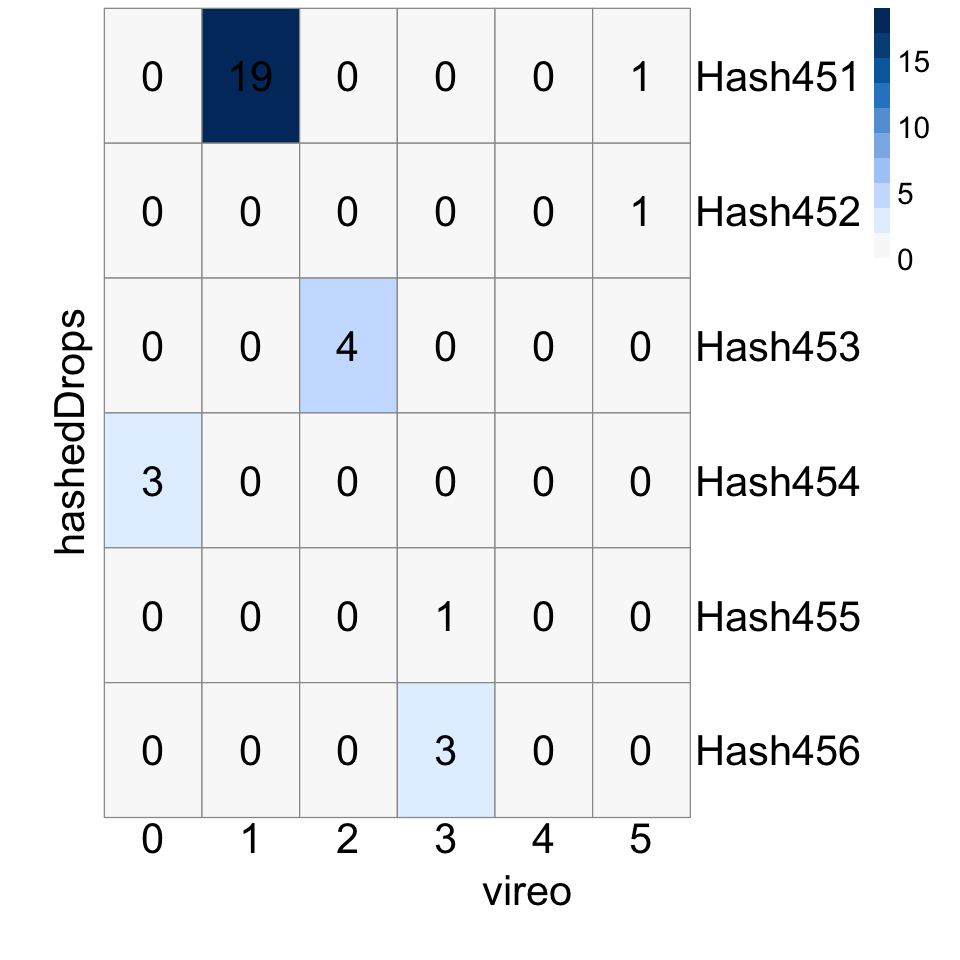

In [14]:
# Create an empyt matrix
confusion_matrix_v_hashedDrops = as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_hashedDrops) = donor_list_vireo
rownames(confusion_matrix_v_hashedDrops) = donor_list

for (j in c(0:5)){
  for (i in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$vireo == donor_list_vireo[j+1] &
                                  hash_gene_result$hashedDrops == donor_list[i],])
    confusion_matrix_v_hashedDrops[i, j+1] = row
  }
}

confusion_matrix_v_hashedDrops

pdf("S19-heatmap-v-hashedDrops-gx12.pdf", width=11, height=11)

# Change plot size to 8 x 8
options(repr.plot.width=8, repr.plot.height=8)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_hashedDrops, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("hashedDrops", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()